In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Load processed data
df = pd.read_csv('../data/processed/processed_reviews.csv')
print(f"📊 Loaded {len(df)} processed reviews")

📊 Loaded 50000 processed reviews


In [3]:
# Prepare features and labels
X = df['processed_review']
y = df['sentiment']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"📈 Training set size: {len(X_train)}")
print(f"📈 Test set size: {len(X_test)}")
# Feature extraction with TF-IDF
print("\n🔄 Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"✅ Feature matrix shape: {X_train_tfidf.shape}")
print(f"📝 Feature names sample: {tfidf.get_feature_names_out()[:10]}")

📈 Training set size: 40000
📈 Test set size: 10000

🔄 Creating TF-IDF features...
✅ Feature matrix shape: (40000, 5000)
📝 Feature names sample: ['abandoned' 'abc' 'ability' 'able' 'absence' 'absolute' 'absolutely'
 'absolutely nothing' 'absurd' 'abuse']


In [4]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(kernel='linear', random_state=42, probability=True)
}

# Train and evaluate models
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    # Test accuracy
    y_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': test_accuracy
    }

    print(f"✅ {name} - CV: {cv_scores.mean():.4f} (±{cv_scores.std():.4f}), Test: {test_accuracy:.4f}")

# Display results
results_df = pd.DataFrame(results).T
display(results_df)



🔄 Training Logistic Regression...
✅ Logistic Regression - CV: 0.8847 (±0.0038), Test: 0.8898

🔄 Training Naive Bayes...
✅ Naive Bayes - CV: 0.8562 (±0.0038), Test: 0.8584

🔄 Training Random Forest...
✅ Random Forest - CV: 0.8445 (±0.0054), Test: 0.8530


,CV Mean,CV Std,Test Accuracy
Logistic Regression,0.884700,0.003793,0.8898
Naive Bayes,0.856250,0.003833,0.8584
Random Forest,0.844525,0.005413,0.8530


🏆 Best Model: Logistic Regression
🎯 Test Accuracy: 0.8898

📊 Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



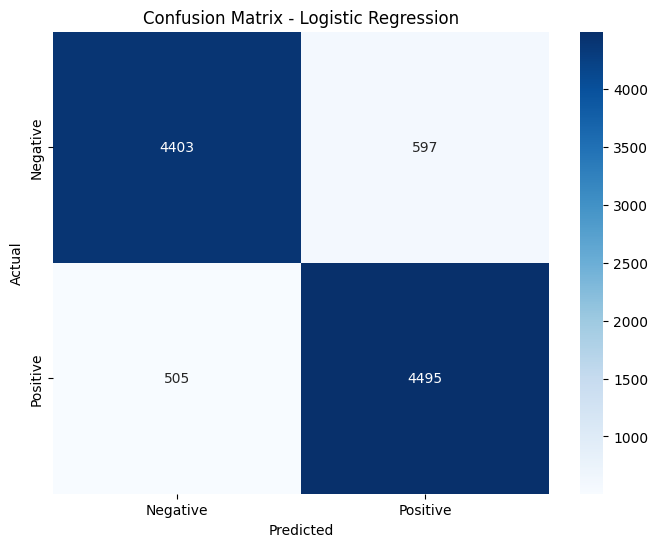


📈 Top 10 Positive Sentiment Features:
excellent: 6.8415
great: 6.3065
perfect: 5.6192
amazing: 5.0614
hilarious: 4.6593
wonderful: 4.6549
loved: 4.3779
favorite: 4.2248
one best: 4.0964
brilliant: 4.0914

📉 Top 10 Negative Sentiment Features:
worst: -9.3654
awful: -7.8245
waste: -7.0731
bad: -6.8455
boring: -6.3444
poor: -5.7727
terrible: -5.5652
dull: -5.3368
poorly: -5.2678
worse: -5.1596


In [6]:
# Select best model (highest test accuracy)
best_model_name = results_df['Test Accuracy'].idxmax()
best_model = trained_models[best_model_name]
print(f"🏆 Best Model: {best_model_name}")
print(f"🎯 Test Accuracy: {results_df.loc[best_model_name, 'Test Accuracy']:.4f}")
# Detailed evaluation
y_pred = best_model.predict(X_test_tfidf)
y_pred_proba = best_model.predict_proba(X_test_tfidf)
print(f"\n📊 Detailed Classification Report:")
print(classification_report(y_test, y_pred))
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Feature importance (for Logistic Regression)
if best_model_name == 'Logistic Regression':
    feature_names = tfidf.get_feature_names_out()
    coefficients = best_model.coef_[0]
    # Top positive features
    top_positive = np.argsort(coefficients)[-10:]
    # Top negative features
    top_negative = np.argsort(coefficients)[:10]

    print("\n📈 Top 10 Positive Sentiment Features:")
    for i in reversed(top_positive):
        print(f"{feature_names[i]}: {coefficients[i]:.4f}")
    print("\n📉 Top 10 Negative Sentiment Features:")
    for i in top_negative:
        print(f"{feature_names[i]}: {coefficients[i]:.4f}")

In [10]:
#Save the best model and vectorizer
joblib.dump(best_model,
f'../models/best_sentiment_model_{best_model_name.lower().replace(" ", "_")}.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')
print(f"💾 Model saved: ../models/best_sentiment_model_{best_model_name.lower().replace(' ', '_')}.pkl")
print(f"💾 Vectorizer saved: ../models/tfidf_vectorizer.pkl")
# Create model info
model_info = {
'model_type': best_model_name,
'test_accuracy': results_df.loc[best_model_name, 'Test Accuracy'],
'cv_mean': results_df.loc[best_model_name, 'CV Mean'],
'cv_std': results_df.loc[best_model_name, 'CV Std'],
'features': X_train_tfidf.shape[1]
}
# Save model info
import json
with open('../models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("📋 Model information saved to ../models/model_info.json")


💾 Model saved: ../models/best_sentiment_model_logistic_regression.pkl
💾 Vectorizer saved: ../models/tfidf_vectorizer.pkl
📋 Model information saved to ../models/model_info.json
